In [11]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage import color, data, restoration
import scipy

## Use off-the shelf Wiener Deconvolution as baseline

In [13]:
img = data.camera() / 255.0

## Some PSFs

In [14]:
def get_gaussian_psf(k_size, std):
    gaussian_1d = scipy.signal.windows.gaussian(k_size, std).reshape(k_size, 1)
    gaussian_kernel = gaussian_1d @ gaussian_1d.T
    gaussian_kernel /= np.sum(gaussian_kernel)

    return gaussian_kernel

def get_box_psf(k_size):
    return np.ones((k_size, k_size))/ (k_size**2)

def get_circle_psf(k_size):
    radius = k_size//2
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x*x + y*y <= radius*radius
    circle = np.zeros((k_size, k_size))
    circle[mask] = 1.0
    return circle / np.sum(circle)

In [33]:
psf = get_gaussian_psf(9, 1.5)

blurry = scipy.signal.convolve2d(img, psf, mode='same')
noisy = blurry + 0.04 * np.random.randn(img.shape[0], img.shape[1])
noisy = np.clip(noisy,0,1)

deblurred = restoration.wiener(noisy, psf, 0.5)
deblurred = (deblurred - np.min(deblurred)) / (np.max(deblurred) - np.min(deblurred))

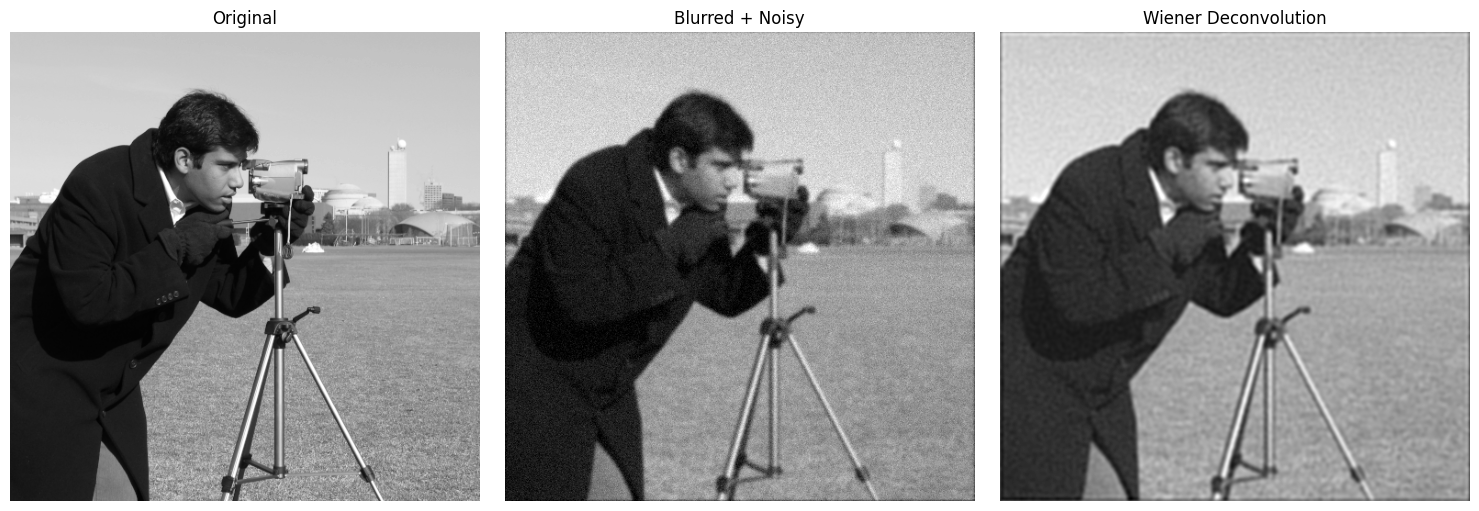

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(img, cmap='gray')
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(noisy, cmap='gray')
ax2.set_title('Blurred + Noisy')
ax2.axis('off')

ax3.imshow(deblurred, cmap='gray')
ax3.set_title('Wiener Deconvolution')
ax3.axis('off')

plt.tight_layout()
plt.show()


## Comparison with ADMM:

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:01<00:00, 17.17it/s]


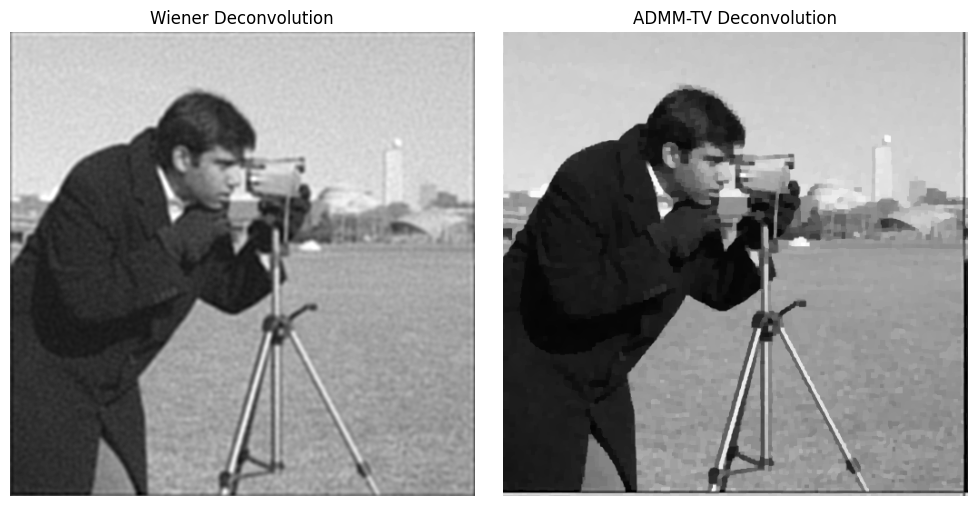

In [35]:
from admm import ADMMTVSolver

DeconvSolver = ADMMTVSolver(noisy, psf, lmda=0.01, rho=0.2, log=True)
admm_deblurred = DeconvSolver.solve(n_iters=30)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(deblurred, cmap='gray')
ax1.set_title('Wiener Deconvolution')
ax1.axis('off')

ax2.imshow(admm_deblurred, cmap='gray')
ax2.set_title('ADMM-TV Deconvolution')
ax2.axis('off')

plt.tight_layout()
plt.show()
